# **G-Continuous Cubic Bézier Interpolation**
by Dhonan Nabil Hibatullah

## **1. Arm and Leg Movement are Configured Separately?**

It is a common technique in designing dancing robot movement, where arm and leg are considered as two separate parts. The question is, how to connect both movements in a single communication bus to all the servos? This can be a very difficult task, if one is not considering the existence of interpolation!

Given two movement sequences $\mathbf{\theta}_{arm}^{(i)}$ and $\mathbf{\theta}_{leg}^{(j)}$ with its corresponding target time $\tau_{arm}^{(i)}$ and $\tau_{leg}^{(j)}$. We can construct a smooth interpolation between the $k$ and $k+1$ movement with:


$$\mathbf{P}_{k, k+1}(s) = (1-s)^{3}\mathbf{P}_{k} + 3s(1-s)^2\mathbf{Q}_{k}^{+} + 3s^2(1-s)\mathbf{Q}_{k+1}^{-} + s^3\mathbf{P}_{k+1}$$


where $\mathbf{P}_{k} = (\tau^{(k)}, \theta^{(k)})$ , $s \in [0, 1]$, $\mathbf{Q}_{k}^{-} = (\tau_{k}^{-}, \theta_{k}^{-})$ and $\mathbf{Q}_{k}^{+} = (\tau_{k}^{+}, \theta_{k}^{+})$ are pre- and post- control point of given $\mathbf{P}_k$ respectively. This [video](https://www.youtube.com/watch?v=aVwxzDHniEw) gives a really good explanation about what is happening behind this so-called Bézier curve.


## **2. Constraint of $\mathbf{Q}_k^-$ and $\mathbf{Q}_k^+$**

It can be proven easily that for the interpolation to work as a function, the following constraints must be satisfied:

- $\tau_k^{+}, \tau_{k+1}^{-} \in \left[\tau^{(k)}, \tau^{(k+1)}\right]$

- $\theta^{(k)} = \theta_k^+$ and $\theta^{(k+1)} = \theta_{k+1}^-$

In other words, $\mathbf{Q}_k^+$ and $\mathbf{Q}_{k+1}^-$ lie on horizontal segments of a rectangle constructed by $\mathbf{P}_k$ and $\mathbf{P}_{k+1}$.

## **3. Finding $s$ from $\tau$**

To combine the arm and leg movements, we have to know the value of $s$ from given $\tau$. This can be determined with the help of Newton-Raphson iteration. The map $\tau \mapsto s$ comes from:

$$f(s) = (-\tau^{(k)} + 3\tau_k^+ - 3\tau_{k+1}^- + \tau^{(k+1)})s^3 + (3\tau^{(k)} - 6\tau_k^+ + 3\tau_{k+1}^-)s^2 + (-3\tau^{(k)} + 3\tau_k^+)s + \tau^{(k)} - \tau = 0$$

$$s_{n+1} = s_{n} - \frac{f(s_n)}{f'(s_n)}$$

## **4. Example**
The following shows a working example of the interpolation.

Importing modules:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

Displaying raw data:

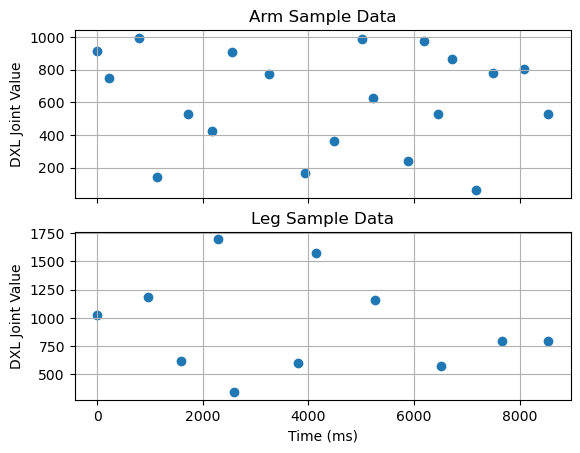

In [10]:
with open('arm_example.yaml', 'r') as file:
    arm_yaml    = yaml.safe_load(file)
    arm_data    = arm_yaml['val']
    arm_val     = [data[0] for data in arm_data]
    arm_time    = [data[1] for data in arm_data]

with open('leg_example.yaml', 'r') as file:
    leg_yaml    = yaml.safe_load(file)
    leg_data    = leg_yaml['val']
    leg_val     = [data[0] for data in leg_data]
    leg_time    = [data[1] for data in leg_data]



fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(arm_time, arm_val)
ax[0].set_title('Arm Sample Data')
ax[0].set_ylabel('DXL Joint Value')
ax[0].grid()

ax[1].scatter(leg_time, leg_val)
ax[1].set_title('Leg Sample Data')
ax[1].set_ylabel('DXL Joint Value')
ax[1].set_xlabel('Time (ms)')
ax[1].grid()

plt.show()

Interpolate data:

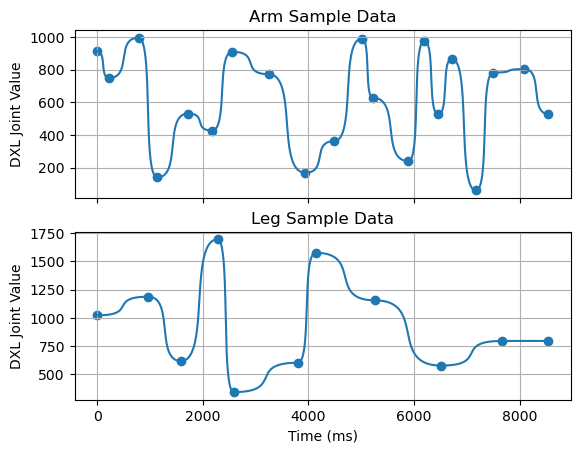

In [26]:
Q_PROPORTTION   = 0.8
s_arr           = np.linspace(0.0, 1.0, 100)


tau_arm_plus    = []
tau_arm_min     = []

for i in range(len(arm_data)):
    if i == 0: continue
    tau_arm_plus.append(arm_time[i - 1] + (arm_time[i] - arm_time[i - 1])*Q_PROPORTTION)
    tau_arm_min.append(arm_time[i - 1] + (arm_time[i] - arm_time[i - 1])*(1.0 - Q_PROPORTTION))

lerp_arm_theta  = []
lerp_arm_tau    = []
for i in range(len(arm_data) - 1):
    lerp_arm_theta += list(
        ((1.0 - s_arr)**3.0)*arm_val[i] + 
        (3.0*s_arr*(1.0 - s_arr)**2.0)*arm_val[i] + 
        (3.0*(s_arr**2.0)*(1.0 - s_arr))*arm_val[i + 1] + 
        (s_arr**3.0)*arm_val[i + 1]
    )

    lerp_arm_tau += list(
        ((1.0 - s_arr)**3.0)*arm_time[i] + 
        (3.0*s_arr*(1.0 - s_arr)**2.0)*tau_arm_plus[i] + 
        (3.0*(s_arr**2.0)*(1.0 - s_arr))*tau_arm_min[i] + 
        (s_arr**3.0)*arm_time[i + 1]
    )


tau_leg_plus    = []
tau_leg_min     = []

for i in range(len(leg_data)):
    if i == 0: continue
    tau_leg_plus.append(leg_time[i - 1] + (leg_time[i] - leg_time[i - 1])*Q_PROPORTTION)
    tau_leg_min.append(leg_time[i - 1] + (leg_time[i] - leg_time[i - 1])*(1.0 - Q_PROPORTTION))

lerp_leg_theta  = []
lerp_leg_tau    = []
for i in range(len(leg_data) - 1):
    lerp_leg_theta += list(
        ((1.0 - s_arr)**3.0)*leg_val[i] + 
        (3.0*s_arr*(1.0 - s_arr)**2.0)*leg_val[i] + 
        (3.0*(s_arr**2.0)*(1.0 - s_arr))*leg_val[i + 1] + 
        (s_arr**3.0)*leg_val[i + 1]
    )

    lerp_leg_tau += list(
        ((1.0 - s_arr)**3.0)*leg_time[i] + 
        (3.0*s_arr*(1.0 - s_arr)**2.0)*tau_leg_plus[i] + 
        (3.0*(s_arr**2.0)*(1.0 - s_arr))*tau_leg_min[i] + 
        (s_arr**3.0)*leg_time[i + 1]
    )

fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].scatter(arm_time, arm_val)
ax[0].plot(lerp_arm_tau, lerp_arm_theta)
ax[0].set_title('Arm Sample Data')
ax[0].set_ylabel('DXL Joint Value')
ax[0].grid()

ax[1].scatter(leg_time, leg_val)
ax[1].plot(lerp_leg_tau, lerp_leg_theta)
ax[1].set_title('Leg Sample Data')
ax[1].set_ylabel('DXL Joint Value')
ax[1].set_xlabel('Time (ms)')
ax[1].grid()

plt.show()

Take time sampling:

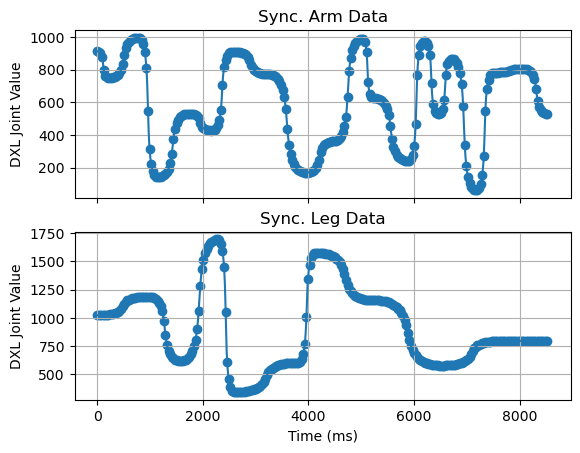

In [29]:
def calculate_s(tk0:float, tk0p:float, tk1m:float, tk1:float, tau:float) -> float:
    c1 = -tk0 + 3*tk0p - 3*tk1m + tk1
    c2 = 3*tk0 - 6*tk0p + 3*tk1m
    c3 = -3*tk0 + 3*tk0p
    c4 = tk0 - tau

    s_n = 0.5
    for i in range(10):
        f_val       = c1*(s_n**3.0) + c2*(s_n**2.0) + c3*(s_n) + c4
        f_dot_val   = 3.0*c1*(s_n**2.0) + 2.0*c2*s_n + c3
        s_n         = s_n - f_val/f_dot_val

    return s_n


DELTA_TIME = 30

time_min        = 0
time_max        = arm_time[-1]
timestep        = np.arange(time_min, time_max, DELTA_TIME)
arm_time_iter   = iter(arm_time)
leg_time_iter   = iter(leg_time)

res_arm_theta = []
res_leg_theta = []

arm_idx = 1
leg_idx = 1
for t in timestep:
    if t > arm_time[arm_idx]: arm_idx += 1
    if t > leg_time[leg_idx]: leg_idx += 1

    s_arm = calculate_s(arm_time[arm_idx - 1], tau_arm_plus[arm_idx - 1], tau_arm_min[arm_idx - 1], arm_time[arm_idx], t)
    s_leg = calculate_s(leg_time[leg_idx - 1], tau_leg_plus[leg_idx - 1], tau_leg_min[leg_idx - 1], leg_time[leg_idx], t)

    res_arm_theta.append(
        ((1.0 - s_arm)**3.0)*arm_val[arm_idx - 1] + 
        (3.0*s_arm*(1.0 - s_arm)**2.0)*arm_val[arm_idx - 1] + 
        (3.0*(s_arm**2.0)*(1.0 - s_arm))*arm_val[arm_idx] + 
        (s_arm**3.0)*arm_val[arm_idx]
    )

    res_leg_theta.append(
        ((1.0 - s_leg)**3.0)*leg_val[leg_idx - 1] + 
        (3.0*s_leg*(1.0 - s_leg)**2.0)*leg_val[leg_idx - 1] + 
        (3.0*(s_leg**2.0)*(1.0 - s_leg))*leg_val[leg_idx] + 
        (s_leg**3.0)*leg_val[leg_idx]
    )

    
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(lerp_arm_tau, lerp_arm_theta)
ax[0].scatter(timestep, res_arm_theta)
ax[0].set_title('Sync. Arm Data')
ax[0].set_ylabel('DXL Joint Value')
ax[0].grid()

ax[1].plot(lerp_leg_tau, lerp_leg_theta)
ax[1].scatter(timestep, res_leg_theta)
ax[1].set_title('Sync. Leg Data')
ax[1].set_ylabel('DXL Joint Value')
ax[1].set_xlabel('Time (ms)')
ax[1].grid()

plt.show()